In [1]:
import sys, subprocess, importlib
def pip_try(*pkgs):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])
        print("✅", " ".join(pkgs))
    except Exception as e:
        print("⚠️  skip", " ".join(pkgs), "->", e)

pip_try("pandas", "numpy", "scikit-learn", "matplotlib", "joblib", "scipy")
import sklearn, numpy, pandas, scipy
print("Python:", sys.executable)
print("sklearn:", sklearn.__version__)

✅ pandas numpy scikit-learn matplotlib joblib scipy
Python: /bin/python
sklearn: 1.7.2


In [2]:
import os
import re
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode

import scipy.sparse as sp
import joblib

try:
    from IPython.display import display
except Exception:
    pass


In [3]:
class RuleFitLite:
    def __init__(self, n_estimators=100, max_depth=3, min_samples_leaf=10,
                 random_state=42, alpha=10.0):
        self.rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
        )
        self.alpha = float(alpha)
        self.lr = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0/max(self.alpha, 1e-8),
            max_iter=1000,
            tol=1e-3,
            random_state=random_state
        )
        self.classes_ = None

    def _rules_matrix(self, X):
        mats = []
        for est in self.rf.estimators_:
            M = est.decision_path(X)
            if M.shape[1] > 1:
                M = M[:, 1:]
            mats.append(M)
        if len(mats) == 1:
            return mats[0].tocsr()
        return sp.hstack(mats, format="csr")

    def fit(self, X, y):
        X = np.asarray(X)
        self.rf.fit(X, y)
        self.classes_ = np.unique(y)
        R = self._rules_matrix(X)
        self.lr.fit(R, y)
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        R = self._rules_matrix(X)
        return self.lr.predict_proba(R)

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = probs.argmax(axis=1)
        return np.array([self.lr.classes_[i] for i in idx])

In [4]:
DATA_PATH = "./dataset_normalized_clean.csv"
TARGET_COL = "Role"

print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"Target: {TARGET_COL}")
print(f"\nClass distribution:\n{df[TARGET_COL].value_counts()}")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
print(f"\nNumeric features: {len(num_cols)}")

LOADING DATA
Shape: (6854, 28)
Target: Role

Class distribution:
Role
AI ML Specialist                   884
Software Developer                 516
Application Support Engineer       472
Networking Engineer                458
Project Manager                    458
Business Analyst                   442
Cyber Security Specialist          434
Graphics Designer                  415
Helpdesk Engineer                  411
Software tester                    388
Database Administrator             388
Hardware Engineer                  380
Technical Writer                   379
Customer Service Executive         277
API Specialist                     276
Information Security Specialist    276
Name: count, dtype: int64

Numeric features: 27


In [5]:
def categorize_skills(columns):
    soft_skill_keywords = [
        'openness', 'conscientousness', 'extraversion', 'agreeableness', 
        'neuroticism', 'emotional', 'communication', 'leadership', 
        'teamwork', 'creativity', 'critical', 'problem', 'conversation',
        'hedonism', 'enhancement', 'transcendence', 'change'
    ]
    
    hard_skills = []
    soft_skills = []
    
    for col in columns:
        col_lower = col.lower()
        is_soft = any(keyword in col_lower for keyword in soft_skill_keywords)
        
        if is_soft:
            soft_skills.append(col)
        else:
            hard_skills.append(col)
    
    return hard_skills, soft_skills

hard_skill_cols, soft_skill_cols = categorize_skills(num_cols)

print("\n" + "="*60)
print("SKILL CATEGORIZATION")
print("="*60)
print(f"Hard Skills ({len(hard_skill_cols)}): {hard_skill_cols[:3]}...")
print(f"Soft Skills ({len(soft_skill_cols)}): {soft_skill_cols[:3]}...")

X_hard = X[hard_skill_cols].copy()
X_soft = X[soft_skill_cols].copy()
feature_columns = list(X.columns)


SKILL CATEGORIZATION
Hard Skills (15): ['Database Fundamentals', 'Computer Architecture', 'Distributed Computing Systems']...
Soft Skills (12): ['Technical Communication', 'Communication skills', 'Openness']...


In [6]:
print("\n" + "="*60)
print("IMPROVED TRAIN/VAL/TEST SPLIT (60/20/20)")
print("="*60)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

X_train_hard, X_val_hard, X_test_hard = X_train[hard_skill_cols], X_val[hard_skill_cols], X_test[hard_skill_cols]
X_train_soft, X_val_soft, X_test_soft = X_train[soft_skill_cols], X_val[soft_skill_cols], X_test[soft_skill_cols]


IMPROVED TRAIN/VAL/TEST SPLIT (60/20/20)
Train: 4112 (60.0%)
Val:   1371 (20.0%)
Test:  1371 (20.0%)


In [7]:
numeric_transformer_hard = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
preprocess_hard = ColumnTransformer([
    ("num", numeric_transformer_hard, hard_skill_cols)
])

numeric_transformer_soft = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
preprocess_soft = ColumnTransformer([
    ("num", numeric_transformer_soft, soft_skill_cols)
])

print("✅ Preprocessing pipelines created")

✅ Preprocessing pipelines created


In [8]:
print("\n" + "="*60)
print("TRAINING WITH IMPROVED HYPERPARAMETERS")
print("="*60)

# Preprocess
pre_X_train_hard = preprocess_hard.fit_transform(X_train_hard)
pre_X_val_hard = preprocess_hard.transform(X_val_hard)
pre_X_test_hard = preprocess_hard.transform(X_test_hard)

pre_X_train_soft = preprocess_soft.fit_transform(X_train_soft)
pre_X_val_soft = preprocess_soft.transform(X_val_soft)
pre_X_test_soft = preprocess_soft.transform(X_test_soft)


TRAINING WITH IMPROVED HYPERPARAMETERS


In [9]:
print("\nTraining Hard Skills Model...")
rf_lite_hard = RuleFitLite(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=10,
    random_state=42,
    alpha=10.0
)
rf_lite_hard.fit(pre_X_train_hard, y_train)

y_pred_rf_hard_val = rf_lite_hard.predict(pre_X_val_hard)
y_pred_rf_hard_test = rf_lite_hard.predict(pre_X_test_hard)

acc_rf_hard_val = accuracy_score(y_val, y_pred_rf_hard_val)
f1_rf_hard_val = f1_score(y_val, y_pred_rf_hard_val, average="macro")

acc_rf_hard_test = accuracy_score(y_test, y_pred_rf_hard_test)
f1_rf_hard_test = f1_score(y_test, y_pred_rf_hard_test, average="macro")

print(f"  Val  - Acc: {acc_rf_hard_val:.4f}, F1: {f1_rf_hard_val:.4f}")
print(f"  Test - Acc: {acc_rf_hard_test:.4f}, F1: {f1_rf_hard_test:.4f}")



Training Hard Skills Model...
  Val  - Acc: 0.9198, F1: 0.8488
  Test - Acc: 0.9198, F1: 0.8488



CONFUSION MATRIX - HARD SKILLS MODEL


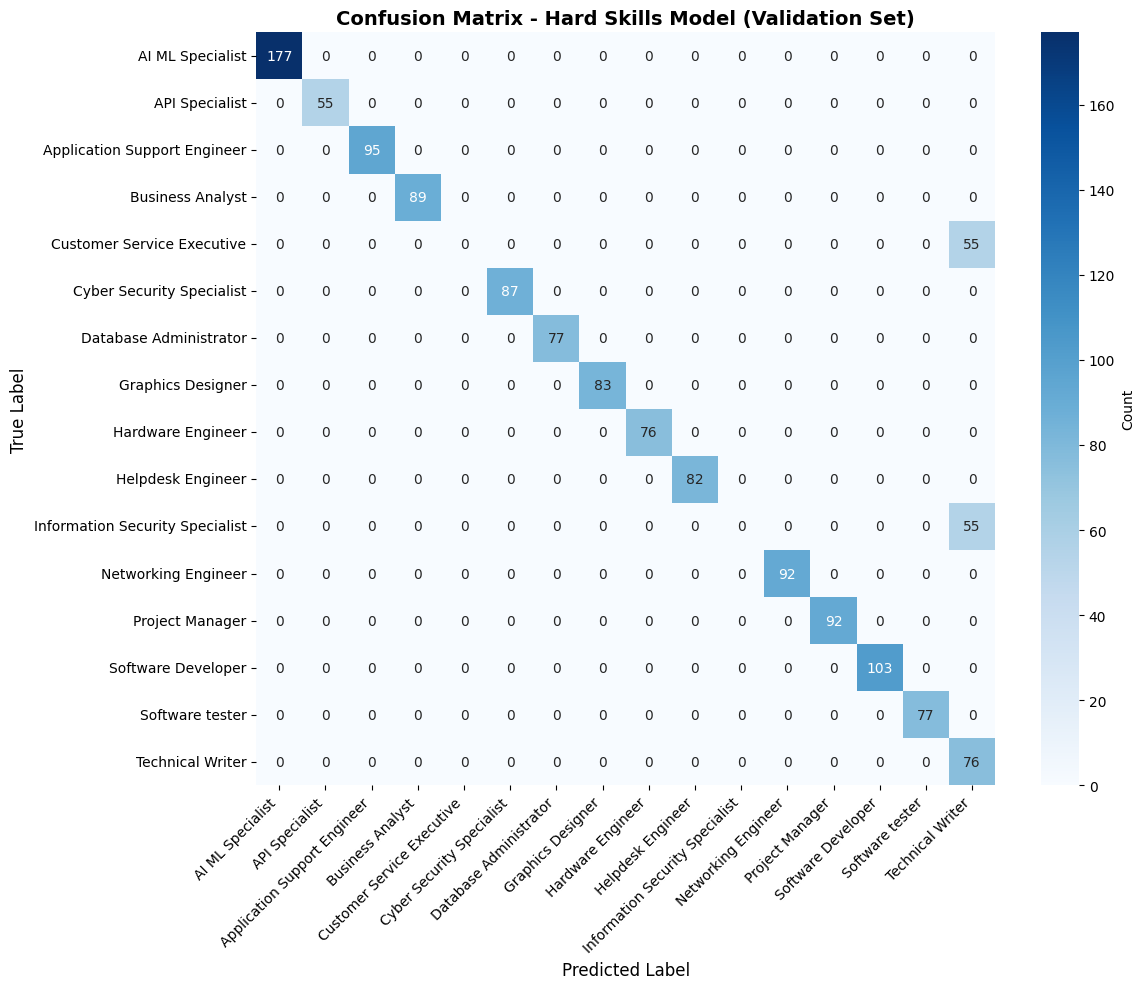

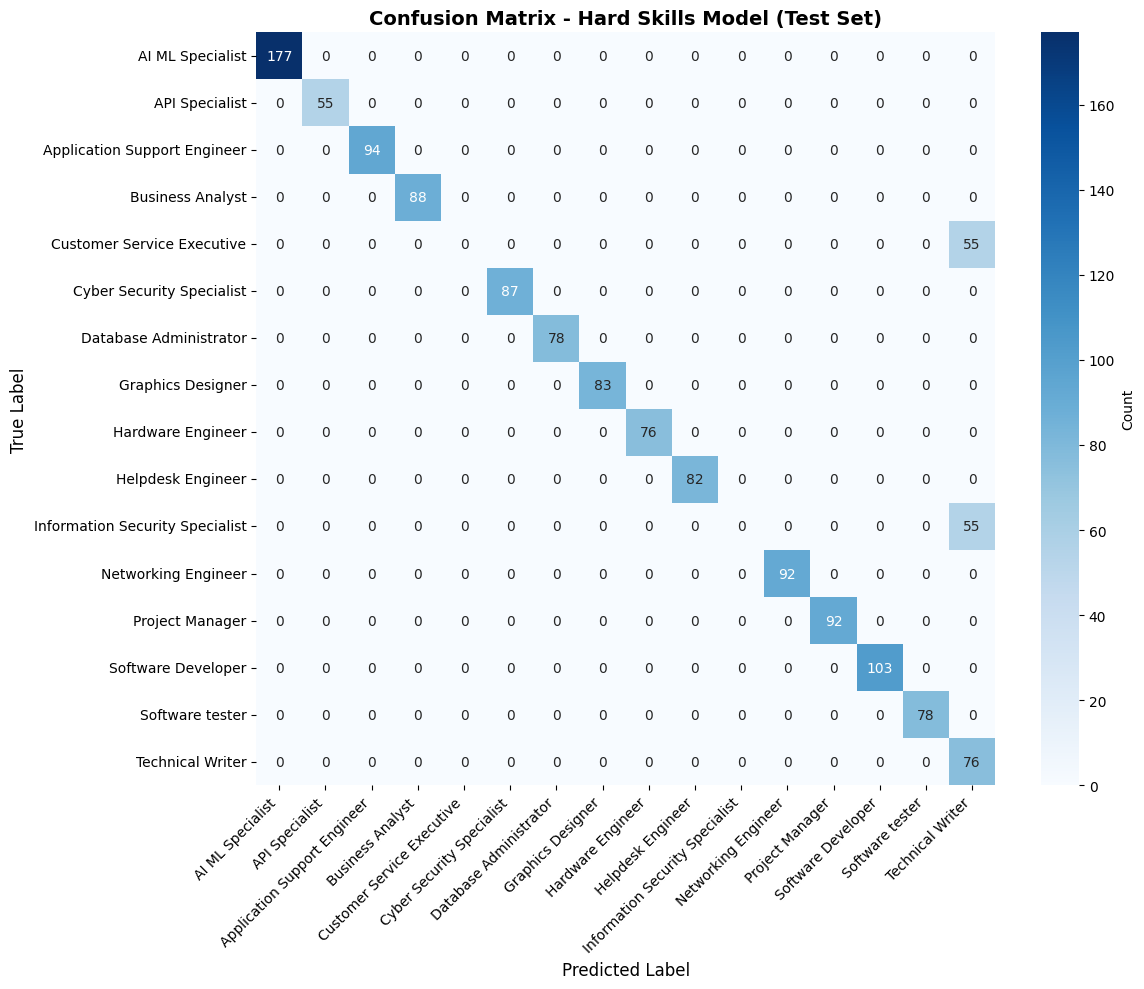


Per-Class Metrics (Hard Skills - Test Set):
                                 precision    recall  f1-score   support

               AI ML Specialist       1.00      1.00      1.00       177
                 API Specialist       1.00      1.00      1.00        55
   Application Support Engineer       1.00      1.00      1.00        94
               Business Analyst       1.00      1.00      1.00        88
     Customer Service Executive       0.00      0.00      0.00        55
      Cyber Security Specialist       1.00      1.00      1.00        87
         Database Administrator       1.00      1.00      1.00        78
              Graphics Designer       1.00      1.00      1.00        83
              Hardware Engineer       1.00      1.00      1.00        76
              Helpdesk Engineer       1.00      1.00      1.00        82
Information Security Specialist       0.00      0.00      0.00        55
            Networking Engineer       1.00      1.00      1.00        92
     

In [10]:
import seaborn as sns

print("\n" + "="*60)
print("CONFUSION MATRIX - HARD SKILLS MODEL")
print("="*60)

# Validation Set
cm_hard_val = confusion_matrix(y_val, y_pred_rf_hard_val)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_hard_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_lite_hard.lr.classes_, 
            yticklabels=rf_lite_hard.lr.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Hard Skills Model (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Test Set
cm_hard_test = confusion_matrix(y_test, y_pred_rf_hard_test)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_hard_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_lite_hard.lr.classes_, 
            yticklabels=rf_lite_hard.lr.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Hard Skills Model (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nPer-Class Metrics (Hard Skills - Test Set):")
print(classification_report(y_test, y_pred_rf_hard_test, target_names=rf_lite_hard.lr.classes_))

In [11]:
print("\nTraining Soft Skills Model...")
rf_lite_soft = RuleFitLite(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=10,
    random_state=42,
    alpha=10.0
)
rf_lite_soft.fit(pre_X_train_soft, y_train)

y_pred_rf_soft_val = rf_lite_soft.predict(pre_X_val_soft)
y_pred_rf_soft_test = rf_lite_soft.predict(pre_X_test_soft)

acc_rf_soft_val = accuracy_score(y_val, y_pred_rf_soft_val)
f1_rf_soft_val = f1_score(y_val, y_pred_rf_soft_val, average="macro")

acc_rf_soft_test = accuracy_score(y_test, y_pred_rf_soft_test)
f1_rf_soft_test = f1_score(y_test, y_pred_rf_soft_test, average="macro")

print(f"  Val  - Acc: {acc_rf_soft_val:.4f}, F1: {f1_rf_soft_val:.4f}")
print(f"  Test - Acc: {acc_rf_soft_test:.4f}, F1: {f1_rf_soft_test:.4f}")


Training Soft Skills Model...
  Val  - Acc: 0.8913, F1: 0.9011
  Test - Acc: 0.8899, F1: 0.8977



CONFUSION MATRIX - SOFT SKILLS MODEL


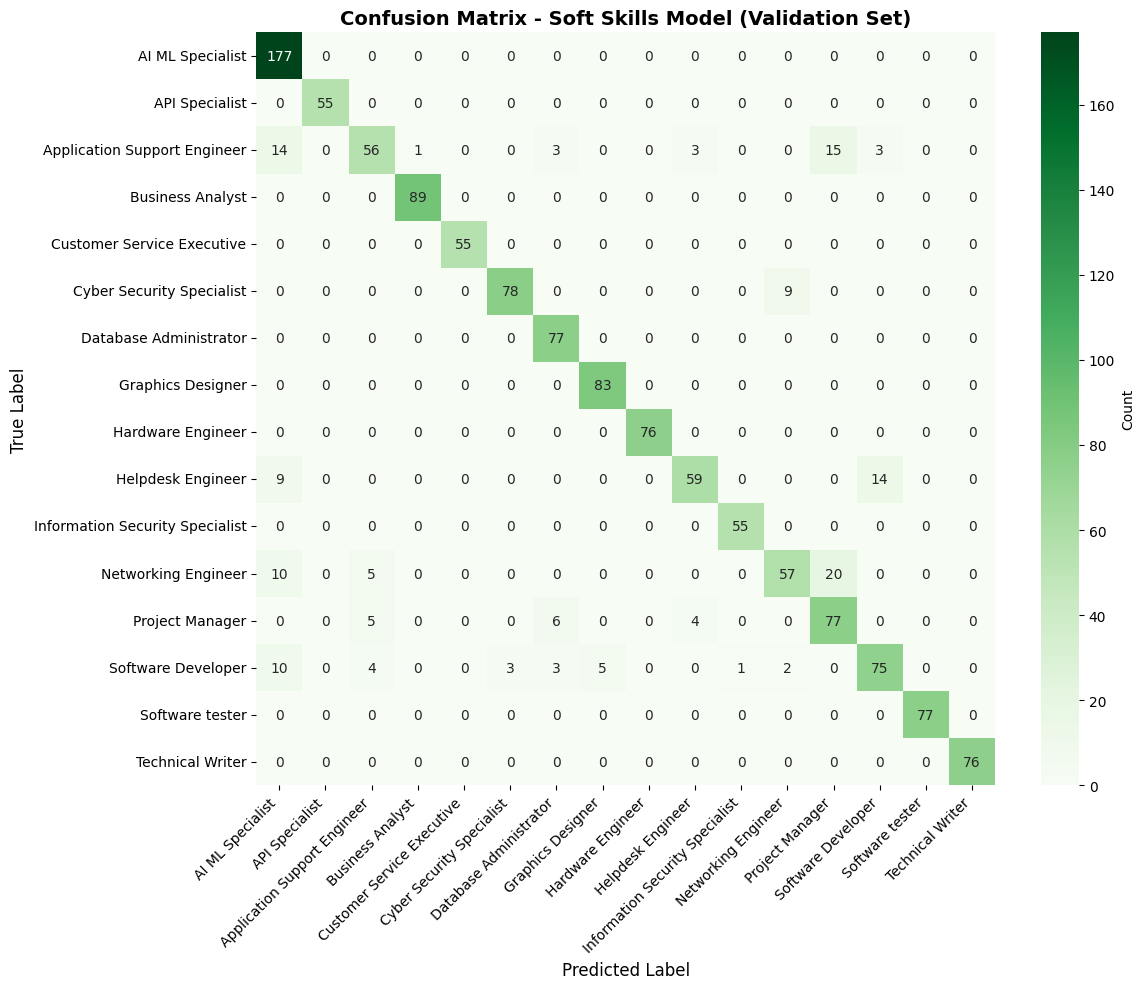

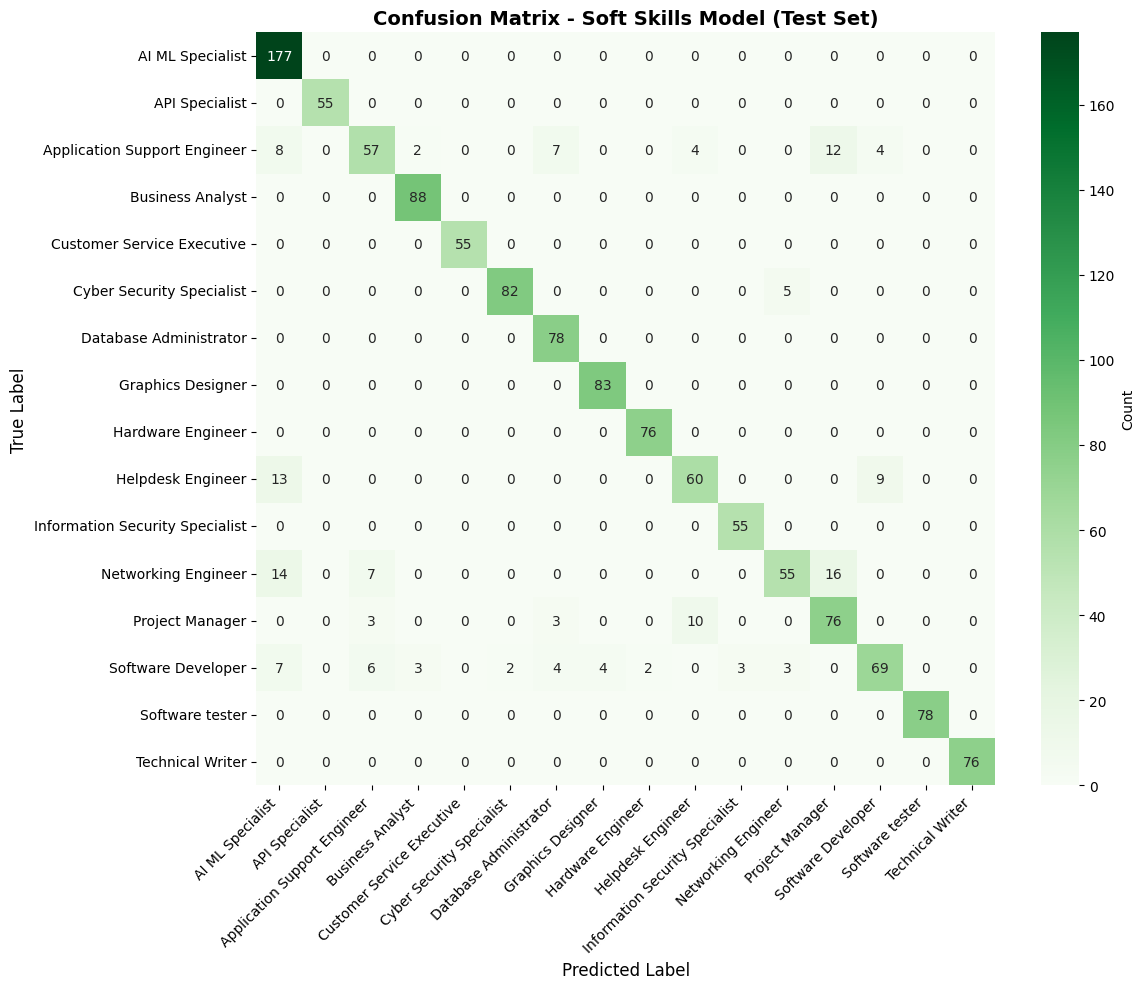


Per-Class Metrics (Soft Skills - Test Set):
                                 precision    recall  f1-score   support

               AI ML Specialist       0.81      1.00      0.89       177
                 API Specialist       1.00      1.00      1.00        55
   Application Support Engineer       0.78      0.61      0.68        94
               Business Analyst       0.95      1.00      0.97        88
     Customer Service Executive       1.00      1.00      1.00        55
      Cyber Security Specialist       0.98      0.94      0.96        87
         Database Administrator       0.85      1.00      0.92        78
              Graphics Designer       0.95      1.00      0.98        83
              Hardware Engineer       0.97      1.00      0.99        76
              Helpdesk Engineer       0.81      0.73      0.77        82
Information Security Specialist       0.95      1.00      0.97        55
            Networking Engineer       0.87      0.60      0.71        92
     

In [12]:
print("\n" + "="*60)
print("CONFUSION MATRIX - SOFT SKILLS MODEL")
print("="*60)

# Validation Set
cm_soft_val = confusion_matrix(y_val, y_pred_rf_soft_val)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_soft_val, annot=True, fmt='d', cmap='Greens', 
            xticklabels=rf_lite_soft.lr.classes_, 
            yticklabels=rf_lite_soft.lr.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Soft Skills Model (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Test Set
cm_soft_test = confusion_matrix(y_test, y_pred_rf_soft_test)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_soft_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=rf_lite_soft.lr.classes_, 
            yticklabels=rf_lite_soft.lr.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Soft Skills Model (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nPer-Class Metrics (Soft Skills - Test Set):")
print(classification_report(y_test, y_pred_rf_soft_test, target_names=rf_lite_soft.lr.classes_))

In [13]:
print("\nEnsemble Predictions...")

proba_hard_val = rf_lite_hard.predict_proba(pre_X_val_hard)
proba_soft_val = rf_lite_soft.predict_proba(pre_X_val_soft)
proba_ensemble_val = 0.6 * proba_hard_val + 0.4 * proba_soft_val
y_pred_ensemble_val = rf_lite_hard.lr.classes_[proba_ensemble_val.argmax(axis=1)]

acc_ensemble_val = accuracy_score(y_val, y_pred_ensemble_val)
f1_ensemble_val = f1_score(y_val, y_pred_ensemble_val, average="macro")

proba_hard_test = rf_lite_hard.predict_proba(pre_X_test_hard)
proba_soft_test = rf_lite_soft.predict_proba(pre_X_test_soft)
proba_ensemble_test = 0.6 * proba_hard_test + 0.4 * proba_soft_test
y_pred_ensemble_test = rf_lite_hard.lr.classes_[proba_ensemble_test.argmax(axis=1)]

acc_ensemble_test = accuracy_score(y_test, y_pred_ensemble_test)
f1_ensemble_test = f1_score(y_test, y_pred_ensemble_test, average="macro")

print(f"  Val  - Acc: {acc_ensemble_val:.4f}, F1: {f1_ensemble_val:.4f}")
print(f"  Test - Acc: {acc_ensemble_test:.4f}, F1: {f1_ensemble_test:.4f}")


Ensemble Predictions...
  Val  - Acc: 1.0000, F1: 1.0000
  Test - Acc: 1.0000, F1: 1.0000



CONFUSION MATRIX - ENSEMBLE MODEL


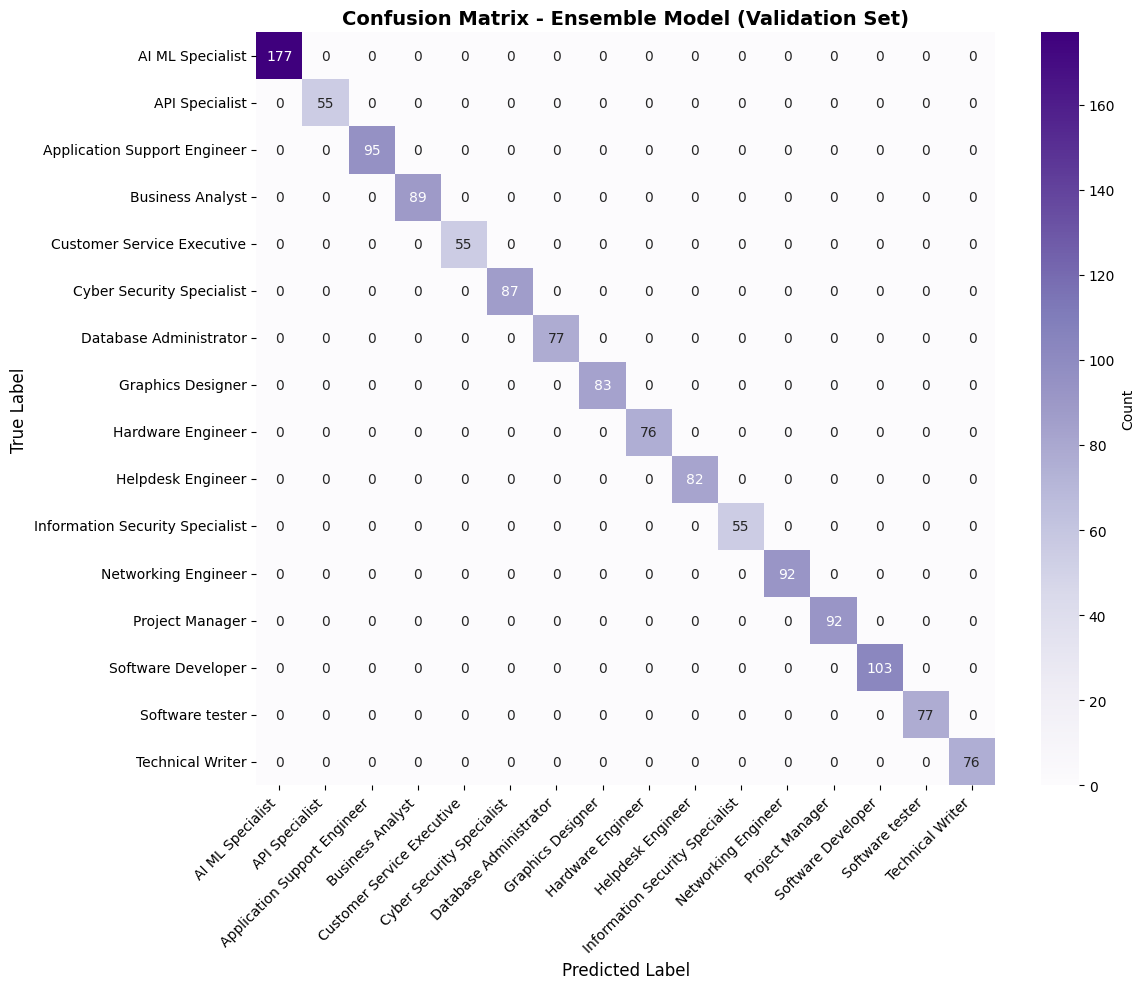

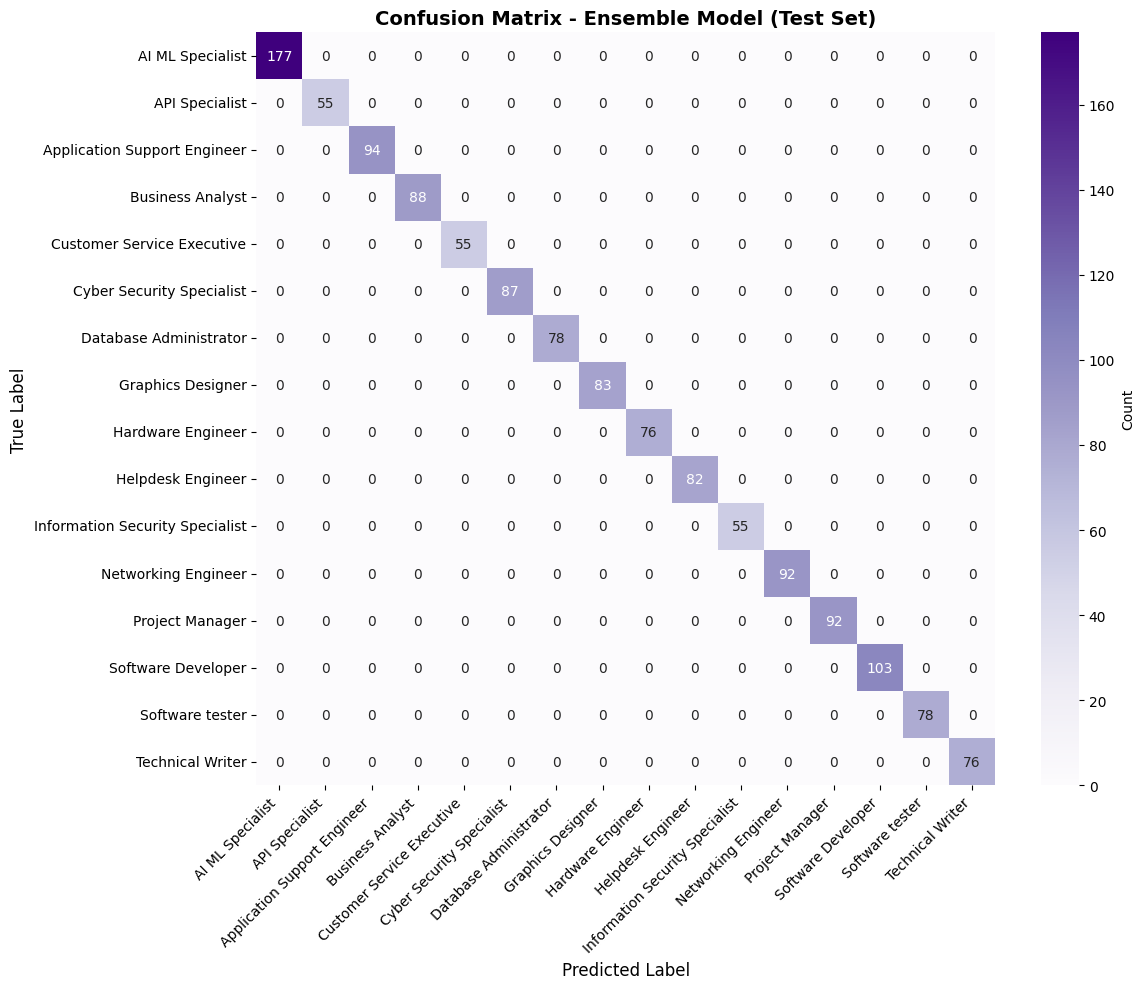


Per-Class Metrics (Ensemble - Test Set):
                                 precision    recall  f1-score   support

               AI ML Specialist       1.00      1.00      1.00       177
                 API Specialist       1.00      1.00      1.00        55
   Application Support Engineer       1.00      1.00      1.00        94
               Business Analyst       1.00      1.00      1.00        88
     Customer Service Executive       1.00      1.00      1.00        55
      Cyber Security Specialist       1.00      1.00      1.00        87
         Database Administrator       1.00      1.00      1.00        78
              Graphics Designer       1.00      1.00      1.00        83
              Hardware Engineer       1.00      1.00      1.00        76
              Helpdesk Engineer       1.00      1.00      1.00        82
Information Security Specialist       1.00      1.00      1.00        55
            Networking Engineer       1.00      1.00      1.00        92
        

In [14]:
print("\n" + "="*60)
print("CONFUSION MATRIX - ENSEMBLE MODEL")
print("="*60)

# Validation Set
cm_ensemble_val = confusion_matrix(y_val, y_pred_ensemble_val)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_ensemble_val, annot=True, fmt='d', cmap='Purples', 
            xticklabels=rf_lite_hard.lr.classes_, 
            yticklabels=rf_lite_hard.lr.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Ensemble Model (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Test Set
cm_ensemble_test = confusion_matrix(y_test, y_pred_ensemble_test)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_ensemble_test, annot=True, fmt='d', cmap='Purples', 
            xticklabels=rf_lite_hard.lr.classes_, 
            yticklabels=rf_lite_hard.lr.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Ensemble Model (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nPer-Class Metrics (Ensemble - Test Set):")
print(classification_report(y_test, y_pred_ensemble_test, target_names=rf_lite_hard.lr.classes_))

In [15]:
print("\n" + "="*60)
print("OVERFITTING CHECK")
print("="*60)

y_pred_train_hard = rf_lite_hard.predict(pre_X_train_hard)
acc_train_hard = accuracy_score(y_train, y_pred_train_hard)

y_pred_train_soft = rf_lite_soft.predict(pre_X_train_soft)
acc_train_soft = accuracy_score(y_train, y_pred_train_soft)

print(f"Hard Skills - Train: {acc_train_hard:.4f}, Val: {acc_rf_hard_val:.4f}, Test: {acc_rf_hard_test:.4f}")
print(f"Soft Skills - Train: {acc_train_soft:.4f}, Val: {acc_rf_soft_val:.4f}, Test: {acc_rf_soft_test:.4f}")

gap_hard = acc_train_hard - acc_rf_hard_test
gap_soft = acc_train_soft - acc_rf_soft_test

print(f"\nGeneralization Gap:")
print(f"  Hard: {gap_hard:.4f} {'⚠️ HIGH' if gap_hard > 0.15 else '✅ OK'}")
print(f"  Soft: {gap_soft:.4f} {'⚠️ HIGH' if gap_soft > 0.15 else '✅ OK'}")

if acc_train_hard > 0.95 or acc_train_soft > 0.95:
    print("\n⚠️  WARNING: Training accuracy > 0.95 - possible overfitting!")
    print("   Consider: further reduce max_depth, increase min_samples_leaf")
else:
    print("\n✅ Training accuracy looks reasonable")


OVERFITTING CHECK
Hard Skills - Train: 0.9190, Val: 0.9198, Test: 0.9198
Soft Skills - Train: 0.9039, Val: 0.8913, Test: 0.8899

Generalization Gap:
  Hard: -0.0007 ✅ OK
  Soft: 0.0141 ✅ OK

✅ Training accuracy looks reasonable


In [16]:
print("\n" + "="*60)
print("SANITY TESTS")
print("="*60)

def predict_jobs_helper(user_data):
    user_data_hard = {k: user_data.get(k, np.nan) for k in hard_skill_cols}
    user_data_soft = {k: user_data.get(k, np.nan) for k in soft_skill_cols}
    
    user_df_hard = pd.DataFrame([user_data_hard])
    user_df_soft = pd.DataFrame([user_data_soft])
    
    user_pre_hard = preprocess_hard.transform(user_df_hard)
    user_pre_soft = preprocess_soft.transform(user_df_soft)
    
    proba_hard = rf_lite_hard.predict_proba(user_pre_hard)[0]
    proba_soft = rf_lite_soft.predict_proba(user_pre_soft)[0]
    proba = 0.6 * proba_hard + 0.4 * proba_soft
    
    top_idx = proba.argmax()
    top_job = rf_lite_hard.lr.classes_[top_idx]
    top_prob = proba[top_idx]
    
    return top_job, top_prob


SANITY TESTS


In [17]:
print("\n1. All skills = 5 (expect: technical/data role)")
all_max = {skill: 5 for skill in feature_columns}
job, prob = predict_jobs_helper(all_max)
print(f"   Result: {job} (prob: {prob:.3f})")
expected_tech = ['Data Scientist', 'AI ML Specialist', 'Software Engineer', 
                 'Software Developer', 'Application Support Engineer']
if any(exp in job for exp in expected_tech):
    print("   ✅ PASS - Got technical role")
else:
    print(f"   ⚠️  UNEXPECTED - Expected technical role, got {job}")


1. All skills = 5 (expect: technical/data role)
   Result: AI ML Specialist (prob: 0.285)
   ✅ PASS - Got technical role


In [18]:
print("\n2. All skills = 1 (expect: entry-level role)")
all_min = {skill: 1 for skill in feature_columns}
job, prob = predict_jobs_helper(all_min)
print(f"   Result: {job} (prob: {prob:.3f})")
print("   ℹ️  No strict expectation for all-low scores")


2. All skills = 1 (expect: entry-level role)
   Result: Software Developer (prob: 0.318)
   ℹ️  No strict expectation for all-low scores


In [19]:
print("\n3. Only hard skills = 5, soft skills = 1")
only_hard = {**{h: 5 for h in hard_skill_cols}, 
             **{s: 1 for s in soft_skill_cols}}
job, prob = predict_jobs_helper(only_hard)
print(f"   Result: {job} (prob: {prob:.3f})")
print("   ℹ️  Should prefer tech-heavy roles")


3. Only hard skills = 5, soft skills = 1
   Result: Software Developer (prob: 0.347)
   ℹ️  Should prefer tech-heavy roles


In [20]:
print("\n4. Only soft skills = 5, hard skills = 1")
only_soft = {**{h: 1 for h in hard_skill_cols}, 
             **{s: 5 for s in soft_skill_cols}}
job, prob = predict_jobs_helper(only_soft)
print(f"   Result: {job} (prob: {prob:.3f})")
expected_soft = ['Business Analyst', 'Project Manager', 'Technical Writer', 
                 'Customer Service Executive']
if any(exp in job for exp in expected_soft):
    print("   ✅ PASS - Got soft-skill role")
else:
    print(f"   ℹ️  Got {job} - may or may not be expected")


4. Only soft skills = 5, hard skills = 1
   Result: Technical Writer (prob: 0.452)
   ✅ PASS - Got soft-skill role


In [21]:
print("\n" + "="*60)
print("SAVING IMPROVED MODEL ARTIFACTS")
print("="*60)

artifacts_dir = "artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

joblib.dump(rf_lite_hard, os.path.join(artifacts_dir, "rf_hard_normalized.pth"))
joblib.dump(rf_lite_soft, os.path.join(artifacts_dir, "rf_soft_normalized.pth"))
joblib.dump(preprocess_hard, os.path.join(artifacts_dir, "preprocess_hard_normalized.pth"))
joblib.dump(preprocess_soft, os.path.join(artifacts_dir, "preprocess_soft_normalized.pth"))

print("✅ Saved model files")


SAVING IMPROVED MODEL ARTIFACTS


✅ Saved model files


In [22]:
metadata = {
    "hard_skills": hard_skill_cols,
    "soft_skills": soft_skill_cols,
    "ensemble_weights": {
        "hard": 0.6,
        "soft": 0.4
    },
    "hyperparameters": {
        "n_estimators": 100,
        "max_depth": 3,
        "min_samples_leaf": 10,
        "alpha": 10.0
    },
    "metrics": {
        "hard_skills": {
            "train_acc": float(acc_train_hard),
            "val_acc": float(acc_rf_hard_val),
            "test_acc": float(acc_rf_hard_test),
            "val_f1": float(f1_rf_hard_val),
            "test_f1": float(f1_rf_hard_test)
        },
        "soft_skills": {
            "train_acc": float(acc_train_soft),
            "val_acc": float(acc_rf_soft_val),
            "test_acc": float(acc_rf_soft_test),
            "val_f1": float(f1_rf_soft_val),
            "test_f1": float(f1_rf_soft_test)
        },
        "ensemble": {
            "val_acc": float(acc_ensemble_val),
            "test_acc": float(acc_ensemble_test),
            "val_f1": float(f1_ensemble_val),
            "test_f1": float(f1_ensemble_test)
        }
    },
    "dataset_shape": df.shape,
    "num_classes": len(y.unique()),
    "train_val_test_split": {
        "train_size": len(X_train),
        "val_size": len(X_val),
        "test_size": len(X_test),
        "random_state": 42
    }
}

with open(os.path.join(artifacts_dir, "model_metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

with open(os.path.join(artifacts_dir, "feature_columns.json"), "w", encoding="utf-8") as f:
    json.dump(feature_columns, f, ensure_ascii=False, indent=2)

print("✅ Saved metadata files")

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"\nFinal Test Results:")
print(f"  Ensemble Accuracy: {acc_ensemble_test:.4f}")
print(f"  Ensemble F1 Macro: {f1_ensemble_test:.4f}")
print(f"\nArtifacts saved to: {artifacts_dir}/")

✅ Saved metadata files

✅ TRAINING COMPLETE!

Final Test Results:
  Ensemble Accuracy: 1.0000
  Ensemble F1 Macro: 1.0000

Artifacts saved to: artifacts/
